<a href="https://colab.research.google.com/github/Imrantipu/-serviceReviewServer/blob/main/cnn_fashion_mnist_gpu_ipynb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torchvision import transforms  # For data augmentation

In [89]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [90]:
# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [91]:
# Load the dataset from a CSV file
try:
    df = pd.read_csv("fmnist_small.csv")  # Load the dataset
    print(df.head())  # Display the first few rows
except Exception as e:
    print(f"Error reading CSV: {e}")

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      9       0       0       0       0       0       0       0       0   
1      7       0       0       0       0       0       0       0       0   
2      0       0       0       0       0       0       1       0       0   
3      8       0       0       0       0       0       0       0       0   
4      8       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         7         0        50       205       196   
1       0  ...         0         0         0         0         0         0   
2       0  ...       142       142       142        21         0         3   
3       0  ...         0         0         0         0         0         0   
4       0  ...       213       203       174       151       188        10   

   pixel781  pixel782  pixel783  pixel784  
0       213       165         

In [92]:
print(df.shape)  # Print the shape of the dataset

(6000, 785)


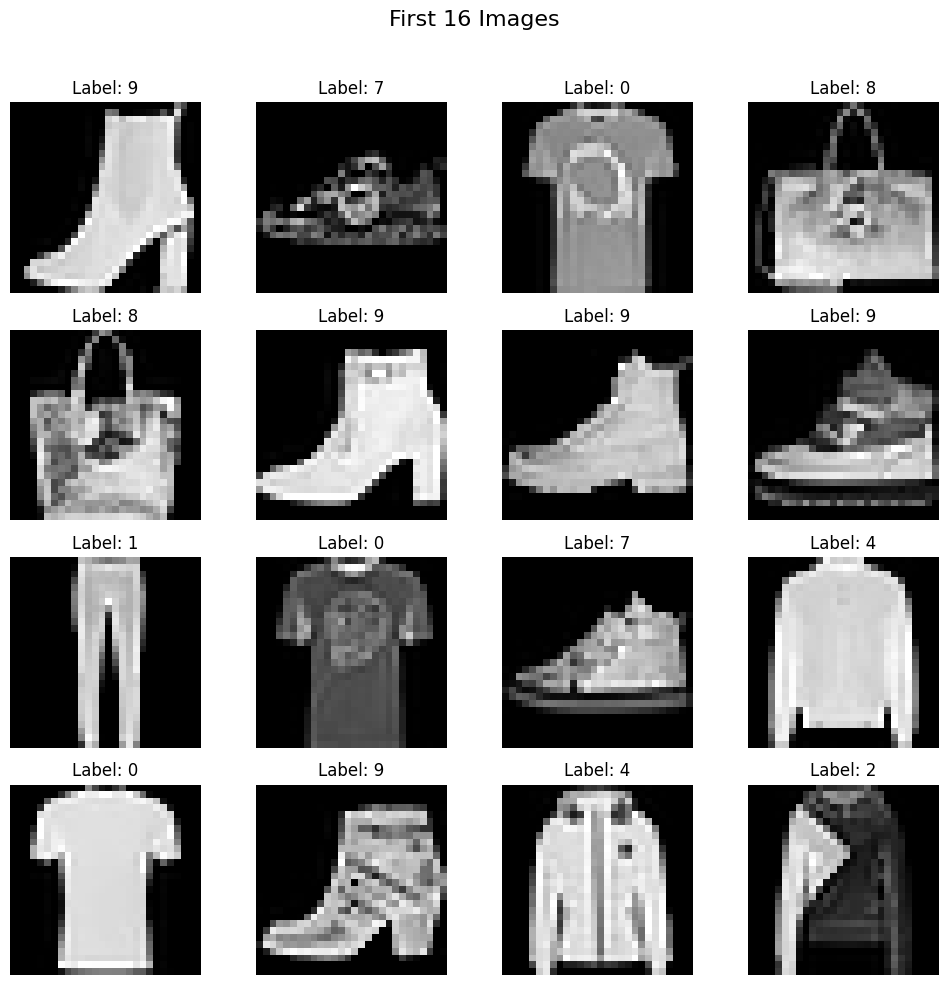

In [93]:
# Create a 4x4 grid of images to visualize the first 16 images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img, cmap='gray')  # Display in grayscale
    ax.axis('off')  # Remove axis
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()  # Uncomment to display the plot

In [94]:
# Split the dataset into training and testing sets
X = df.iloc[:, 1:].values  # Features (pixel values)
y = df.iloc[:, 0].values  # Labels (class labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [95]:
# Define data augmentation transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image for augmentation
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by +/- 10 degrees
    transforms.ToTensor()  # Convert back to tensor
])

In [96]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform  # Data augmentation

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        img = self.features[index]
        if self.transform:
            img = self.transform(img.squeeze(0))  # Apply transformations
        return img, self.labels[index]

In [97]:
# Create training and testing datasets with data augmentation for training
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)


In [98]:
# Define an improved neural network architecture
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),  # Additional layer
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),  # Adjusted input size
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 10)
    )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [99]:
# Set hyperparameters
learning_rate = 0.001  # Reduced learning rate
epochs = 100  # Increased number of epochs

In [100]:
# Initialize the model and move it to the device
model = MyNN(1)
model.to(device)

# Define the loss function and optimizer (Adam for better convergence)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Add a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 0.1 every 5 epochs

In [101]:
# Training loop with early stopping
best_accuracy = 0
patience = 3  # Number of epochs to wait before stopping
epochs_without_improvement = 0

In [102]:
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss}')

    # Evaluation on test data
    model.eval()  # Set model to evaluation mode
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy}')

    # Early stopping logic
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break

    # Step the learning rate scheduler
    scheduler.step()

Epoch: 1, Loss: 1.0613638869921367
Test Accuracy: 0.7491666666666666
Epoch: 2, Loss: 0.6440697538852692
Test Accuracy: 0.8233333333333334
Epoch: 3, Loss: 0.5431059074401855
Test Accuracy: 0.8191666666666667
Epoch: 4, Loss: 0.4699654253323873
Test Accuracy: 0.8366666666666667
Epoch: 5, Loss: 0.440379058321317
Test Accuracy: 0.8425
Epoch: 6, Loss: 0.3590499303738276
Test Accuracy: 0.8475
Epoch: 7, Loss: 0.33394248843193053
Test Accuracy: 0.8508333333333333
Epoch: 8, Loss: 0.3273576237758001
Test Accuracy: 0.8516666666666667
Epoch: 9, Loss: 0.3088418757915497
Test Accuracy: 0.8608333333333333
Epoch: 10, Loss: 0.31084774116675057
Test Accuracy: 0.8625
Epoch: 11, Loss: 0.2959610835711161
Test Accuracy: 0.8616666666666667
Epoch: 12, Loss: 0.2939824020862579
Test Accuracy: 0.8608333333333333
Epoch: 13, Loss: 0.29850361903508504
Test Accuracy: 0.86
Early stopping triggered!


In [103]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9070833333333334
